## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import os
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T20_11_Lille1_1_cylinder_r_0_1414_grid_0_0283_features.npz"""
ROOT2 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T22_37_Lille1_1_cylinder_r_0_2828_grid_0_0566_features.npz"""
ROOT3 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T23_42_Lille1_1_cylinder_r_0_5657_grid_0_1131_features.npz"""
ROOT4 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_30T00_21_Lille1_1_cylinder_r_1_1314_grid_0_2263_features.npz"""
ROOT5 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_30T05_07_Lille1_1_cylinder_r_2_2627_grid_0_4525_features.npz"""
ROOT6 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T19_09_Lille1_1_cylinder_r_4_5255_grid_0_9051_features.npz"""

In [4]:
fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5, ROOT6]
# fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

das = das.astype(np.float32)

# lastFi = np.load(fileList[-1], allow_pickle=True)["array2"]

# das = np.hstack((das, lastFi))

# xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

cls = cls.astype(np.int32)

In [6]:
das.dtype

dtype('float32')

In [7]:
# del lastFi
gc.collect()

113

## Load in points and labels

## Get columns

In [10]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","HeightVariance","HeightRange","count"]

In [11]:

ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
        
    

In [12]:
allCols = ff + ['label']

In [13]:
allAtrs = np.hstack((das, cls.reshape(-1, 1)))

In [14]:
del das, cls

## Create dataframe

In [15]:
allAtrs = allAtrs.astype(np.float32)

In [16]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols).astype('float32')

total_dataframe["label"] = total_dataframe["label"].astype('int32')
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype('int32')
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

    
# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [17]:
gc.collect()

0

In [18]:
# del allAtrs

In [19]:
# ss = ss[ss["count"] > 10]

In [20]:
# total_dataframe.head()

## Create PLY files with features (Only do if they don't already exist)

In [21]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [22]:
# total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
# total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [23]:
# total_dataframe.head()

In [24]:
# total_dataframe.groupby("label").size() / total_dataframe.shape[0]

In [25]:
rf = RandomForestClassifier(verbose=1,n_jobs=16)

In [26]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
total_dataframe.reset_index(inplace = True)

In [28]:
# total_dataframe.head()

In [29]:
gc.collect()

0

In [30]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        if SelectList.shape[0] == 0:
            continue
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState, replace = True)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   


Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished


Current accuracy: 92.5794


Current f1 score: 0.93069


Current f1 score delta: 0.93069
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.2s finished


Current accuracy: 93.7498


Current f1 score: 0.94004


Current f1 score delta: 0.00935
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.5s finished


Current accuracy: 94.2796


Current f1 score: 0.94432


Current f1 score delta: 0.00428
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.4s finished


Current accuracy: 94.6620


Current f1 score: 0.94748


Current f1 score delta: 0.00316
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.7s finished


Current accuracy: 95.1247


Current f1 score: 0.95158


Current f1 score delta: 0.00409
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   57.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 95.3559


Current f1 score: 0.95355


Current f1 score delta: 0.00197
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   57.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 95.5642


Current f1 score: 0.95538


Current f1 score delta: 0.00183
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   57.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.9s finished


Current accuracy: 95.7506


Current f1 score: 0.95706


Current f1 score delta: 0.00168
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   57.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished


Current accuracy: 95.9084


Current f1 score: 0.95845


Current f1 score delta: 0.00139
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.0656


Current f1 score: 0.95981


Current f1 score delta: 0.00136
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   18.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.1235


Current f1 score: 0.96036


Current f1 score delta: 0.00054
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   26.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   17.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.3s finished


Current accuracy: 96.2331


Current f1 score: 0.96128


Current f1 score delta: 0.00093
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.3027


Current f1 score: 0.96191


Current f1 score delta: 0.00063
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   32.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.8s finished


Current accuracy: 96.4144


Current f1 score: 0.96290


Current f1 score delta: 0.00099
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   34.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.4342


Current f1 score: 0.96311


Current f1 score delta: 0.00020
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   36.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.4997


Current f1 score: 0.96370


Current f1 score delta: 0.00060
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   11.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   39.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.5694


Current f1 score: 0.96429


Current f1 score delta: 0.00059
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   11.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   41.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.2s finished


Current accuracy: 96.6407


Current f1 score: 0.96494


Current f1 score delta: 0.00064
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   12.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   45.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.7s finished


Current accuracy: 96.6986


Current f1 score: 0.96548


Current f1 score delta: 0.00055
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   13.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   46.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   17.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.5s finished


Current accuracy: 96.7540


Current f1 score: 0.96597


Current f1 score delta: 0.00048
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   13.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   48.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.8s finished


Current accuracy: 96.7963


Current f1 score: 0.96639


Current f1 score delta: 0.00042
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.0s finished


Current accuracy: 96.8505


Current f1 score: 0.96688


Current f1 score delta: 0.00049
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.6s finished


Current accuracy: 96.8822


Current f1 score: 0.96722


Current f1 score delta: 0.00035
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   59.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.9s finished


Current accuracy: 96.9194


Current f1 score: 0.96749


Current f1 score delta: 0.00027
Starting iteration 25...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.6s finished


Current accuracy: 96.9639


Current f1 score: 0.96795


Current f1 score delta: 0.00046
Starting iteration 26...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   18.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.9960


Current f1 score: 0.96825


Current f1 score delta: 0.00030
Starting iteration 27...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   18.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.8s finished


Current accuracy: 97.0528


Current f1 score: 0.96880


Current f1 score delta: 0.00055
Starting iteration 28...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   19.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.7s finished


Current accuracy: 97.0570


Current f1 score: 0.96884


Current f1 score delta: 0.00004
DONE!!!!


In [31]:
gc.collect()

SelectList.shape

(2134929, 74)

## Plot iterations and accuracy

In [32]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

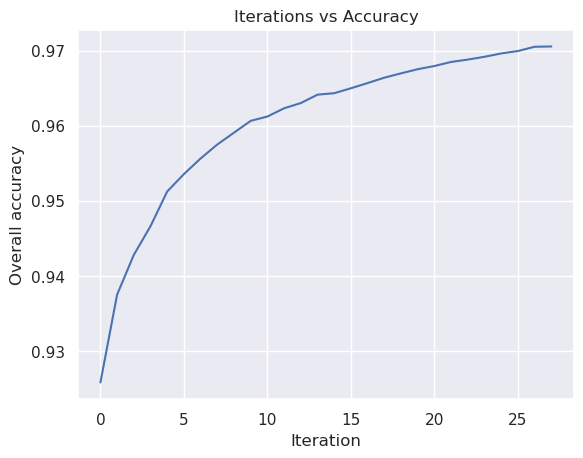

In [33]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [34]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_radial_RF_Lille_Height.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_30_Trained_cylinder_RF_Lille_Height.joblib']

In [35]:
importances = rf.feature_importances_

In [39]:
feature_importance_df = pd.DataFrame({'Feature': ff, 'Importance': importances})

In [42]:
feature_importance_df.sort_values("Importance", ascending = False).to_csv("""./results/cylinder_feature_importance.csv""", index = False)